# Outliers and Kriging

Outliers may affect our analysis and the final interpolation results. In this tutorial, we learn about their influence on the final model and compare interpolation errors for different scenarios. In one set of experiments we clean outliers directly from a dataset, and in another set of experiments we remove outliers from semivariogram.

We can remove too high or too low values at the preprocessing stage (check part 2 of the tutorial) or remove outliers directly from the variogram point cloud (part 4). Results from each type of preprocessing (and a raw dataset analysis) are different, and we will compare them.

## Prerequisites

- **Domain**:
  - semivariance and covariance functions
  - kriging (basics)
  - outliers (statistical concept)
  - variogram point cloud
- **Package**:
  - `TheoreticalVariogram`
  - `ExperimentalVariogram`
  - `ordinary_kriging()`
  - `VariogramCloud()`
- **Programming**:
  - Python basics
  - `pandas` basics

## Table of contents

1. Prepare data
2. Analyze distribution and remove potential outliers
3. Create the Variogram Point Cloud models
4. Remove outliers from the point cloud
5. Compare performance of Ordinary Kriging on data with different cleaning levels

## 1. Prepare data

In [15]:
import geopandas as gpd
import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt

from pyinterpolate import VariogramCloud, build_theoretical_variogram
from pyinterpolate import ordinary_kriging

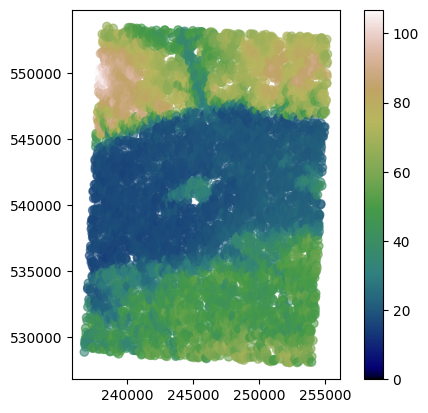

In [2]:
# Load DEM data

df = pd.read_csv(
    '../data/dem.csv'
)
# Populate geometry column and set CRS

dem_geometry = gpd.points_from_xy(x=df['longitude'], y=df['latitude'], crs='epsg:4326')
dem = gpd.GeoDataFrame(df, geometry=dem_geometry)

# Transform crs to metric values
dem.to_crs(epsg=2180, inplace=True)
dem.plot(column='dem', cmap='gist_earth', alpha=0.6, vmin=0, legend=True);

In [3]:
train = dem.sample(n=int(0.02*len(dem)))
test = dem.loc[~dem.index.isin(train.index)]

## 2. Analyze data distribution and remove potential outliers

We will inspect all values in the train set to determine if our dataset contains outliers. In the beginning, we plot data distribution using violin plot, this kind of visulization will show the general distribution.

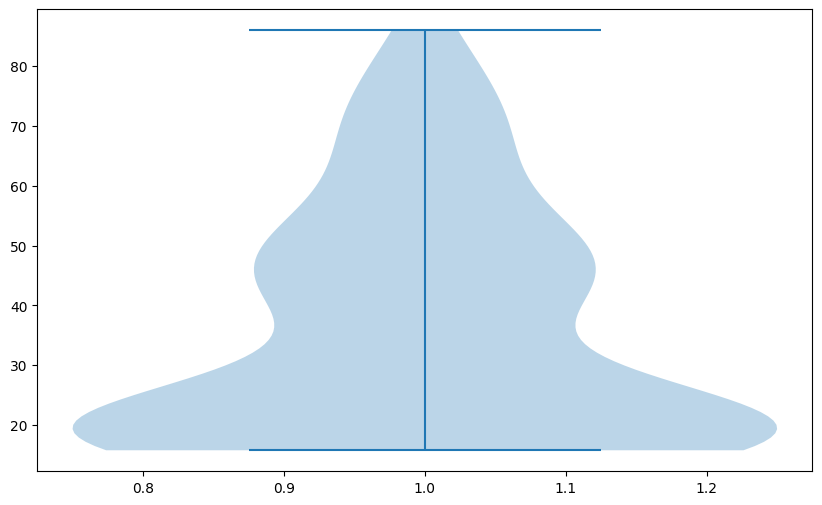

In [5]:
plt.figure(figsize=(10, 6))
plt.violinplot(train['dem'])
plt.show()

> **Note**: Your plot may differ from the tutorial's. Why is that? Because we take a random sample of 2% of values, and after each iteration, the algorithm takes different points for the analysis.

**Clarification**

Investigation of the plot tells us that our data is:

- grouped around the lowest values, and most of the values are below 50 meters
- has (probably) two different distributions mixed, which can be a sign that the Digital Elevation Model covers multiple different types of elevation. One is grouped around 20 meters, the next roughly 50 meters

Violin plot is suitable for the distribution analysis. Finding outliers in this plot may be challenging because we see mostly distributions. We should change a plot type to understand if outliers exist in a dataset. The excellent choice is the boxplot:

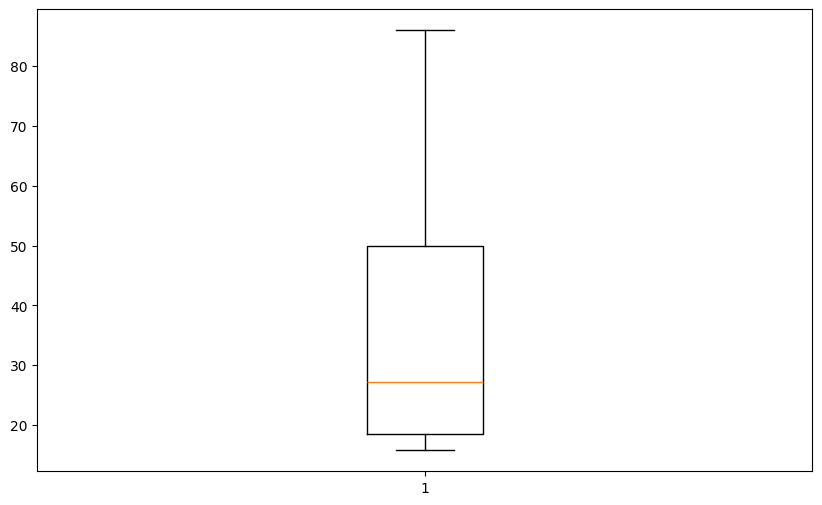

In [6]:
plt.figure(figsize=(10, 6))
plt.boxplot(train['dem'])
plt.show()

**Boxplot** is a handy data visualization tool. Let's analyze this plot from the bottom up to the top.

> **Note**: Boxplot represents values sorted in ascending order and their statistical properties: quartiles, median, and outliers.

- The bottom whisker (horizontal line) represents the lower range of values in our dataset
- The box lower line is the first quartile (*Q1*) of data or, in other words, 25% of values of our dataset are below this point
- The middle line is the median (*Q2*) of our dataset
- The upper line is the third quartile (*Q3*) of a data or, in other words, 75% of values are below this point,
- The top whisker represents the upper range of values in our dataset.
- Individual points (if they exist, then we see them as points below the bottom whisker or above the top whisker) are considered outliers. They could be outliers in the upper range as well as the lower range of our data. The significant distance between Q1 and the bottom whisker or between Q3 and the top whisker indicates potential outliers. Points below or above this distance are treated as outliers. The outlier distance is calculated as $weight * (Q3 - Q1)$  where we can manually set the `weight`, but other parameters are read from data.

We use this knowledge to remove outliers from the dataset. We will manually remove outliers from the data, assuming that outliers are placed one standard deviation from Q1 (down) and Q3 (up).

In [7]:
# Create training set without outliers

q1 = np.quantile(train['dem'], 0.25)
q3 = np.quantile(train['dem'], 0.75)

top_limit = q3 + (q3 - q1)

train_without_outliers = train[train['dem'] < top_limit]

Length of the full training set is 137 records
Length of the pre-processed training set is 134 records


In [9]:
train['dem'].describe()

count    137.000000
mean      35.978416
std       20.105216
min       15.787008
25%       18.463264
50%       27.259899
75%       49.956329
max       85.972084
Name: dem, dtype: float64

In [10]:
train_without_outliers['dem'].describe()

count    134.000000
mean      34.889803
std       18.940992
min       15.787008
25%       18.443832
50%       26.171080
75%       48.846126
max       79.730095
Name: dem, dtype: float64

**Clarification**

Mean and standard deviation of transformed dataset are lower, and the maximal value is different than in the raw training set. Does this transformation affect modeling? We will see in the next steps.

## 3. Create Variogram Clouds

Now, we are going one step further, and we will transform both datasets with- and without- outliers and calculate variogram point clouds. Then, we compare both clouds.

In [19]:
step_size = 1000  # meters
max_range = 10000  # meters

In [20]:
cloud_with = VariogramCloud(
    ds=train[['geometry', 'dem']],
    step_size=step_size,
    max_range=max_range
)

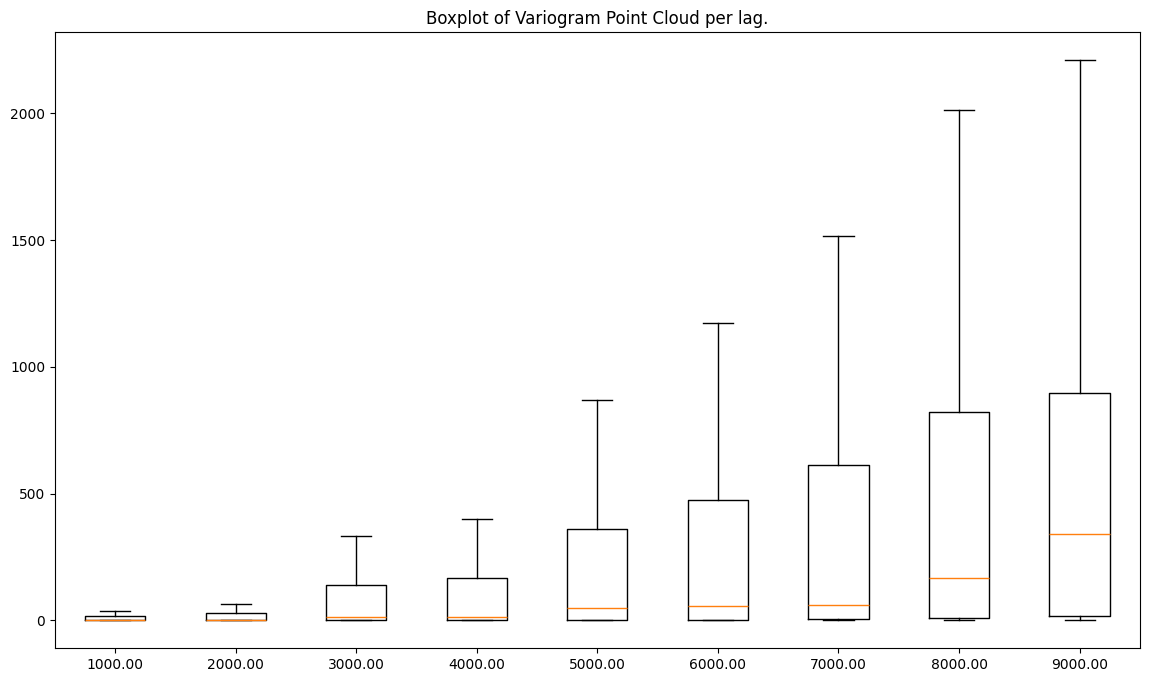

True

In [21]:
cloud_with.plot('box')

In [22]:
cloud_without = VariogramCloud(
    ds=train_without_outliers[['geometry', 'dem']],
    step_size=step_size,
    max_range=max_range
)

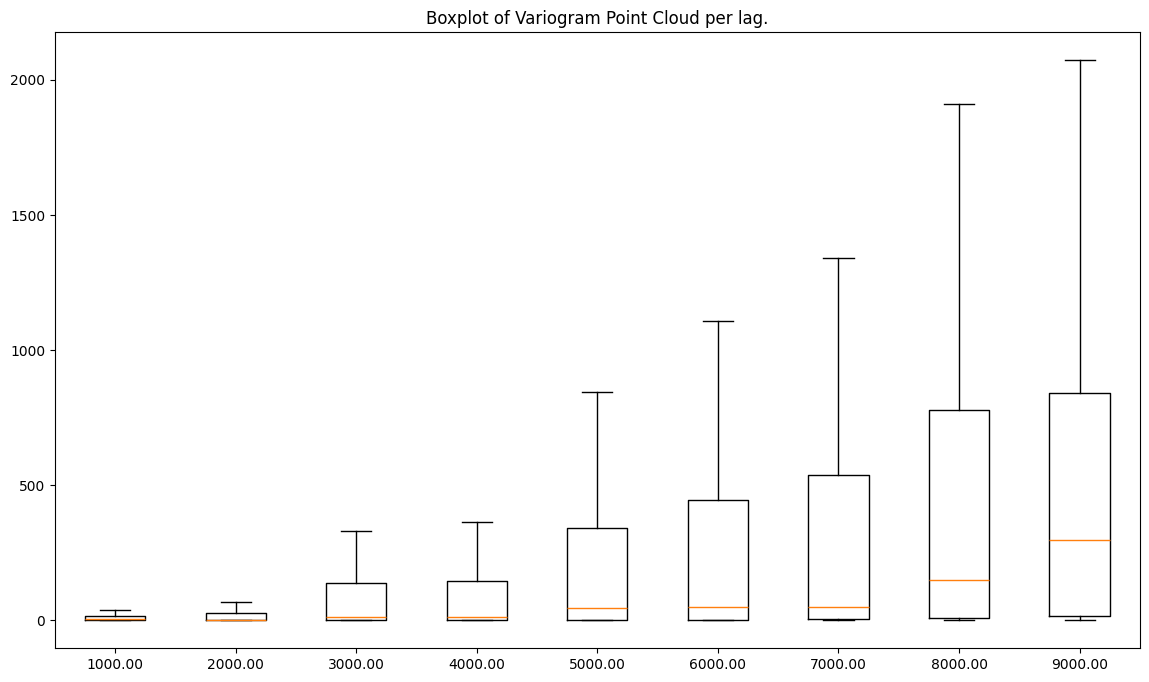

True

In [23]:
cloud_without.plot('box')

**Clarification**

The processed dataset has lower semivariances than the raw readings, and both variograms have a similar shape.

In the next cell, we will check a standard deviation of semivariances for each lag.

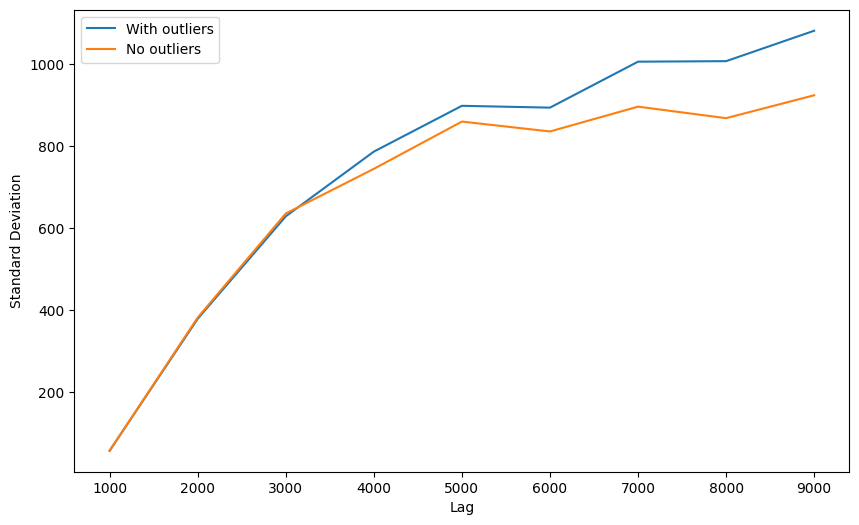

In [29]:
with_stats = cloud_with.describe()
without_stats = cloud_without.describe()

with_stds = []
without_stds = []
lags = []
for lag in with_stats:
    lags.append(lag)
    with_stds.append(with_stats[lag]['std'])
    without_stds.append(without_stats[lag]['std'])

plt.figure(figsize=(10, 6))
plt.plot(lags, with_stds)
plt.plot(lags, without_stds)
plt.legend(['With outliers', 'No outliers'])
plt.xlabel('Lag')
plt.ylabel('Standard Deviation')
plt.show()

**Clarification**

Data cleaning brings the best outcomes to more distant lags. Why? Because those lags group the largest sets of point pairs, and outlier influence is amplified by number of pairs with those outliers.

It doesn't mean that the bottom semivariogram is better, especially when we consider the fact, that closest bins are those most important. We should proceed with experiments.

## 4. Remove outliers from the point cloud

In this step, we will use `VariogramCloud` method `.remove_outliers()` to build two additional variogram point clouds from the raw and processed datasets.

